In [ ]:
!pip install pip-tools
!pip-compile --upgrade
!pip-sync

In [ ]:
!pip -q install -U datasets pillow matplotlib


In [ ]:
!pip install "numpy<2" -U

In [4]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
import os, io

In [5]:
DS_ID = "itsanmolgupta/mimic-cxr-dataset"
ds = load_dataset(DS_ID, token=os.getenv("HF_TOKEN"))

In [6]:
from datasets import load_dataset

# Load a small portion of the train split
train = load_dataset(DS_ID, split="train[:100]", token=HF_TOKEN)

# Try loading validation split, fallback to splitting train if missing
try:
    val = load_dataset(DS_ID, split="validation[:50]", token=HF_TOKEN)
except ValueError:
    # No validation split → take a portion of train
    val = load_dataset(DS_ID, split="train[100:150]", token=HF_TOKEN)

# Try loading test split, fallback to None if missing
try:
    test = load_dataset(DS_ID, split="test[:50]", token=HF_TOKEN)
except ValueError:
    test = None

# Print summary
print("Splits → train/val/test:", len(train), len(val), (len(test) if test else 0))
print("Columns:", train.column_names)
print("Features:", train.features)

Splits → train/val/test: 100 50 0
Columns: ['image', 'findings', 'impression']
Features: {'image': Image(mode=None, decode=True), 'findings': Value('string'), 'impression': Value('string')}


In [7]:
# Quick peek at first 3 rows (types only, to avoid dumping big blobs)
for i in range(min(3, len(train))):
    print(f"Row {i} types:", {k: type(train[i][k]).__name__ for k in train.column_names})

Row 0 types: {'image': 'JpegImageFile', 'findings': 'str', 'impression': 'str'}
Row 1 types: {'image': 'JpegImageFile', 'findings': 'str', 'impression': 'str'}
Row 2 types: {'image': 'JpegImageFile', 'findings': 'str', 'impression': 'str'}


In [8]:
# Detect common image/text columns
image_col = next((c for c in ["image","pil_image","img","pixel_values","image_path","filepath"] if c in train.column_names), None)
text_col  = next((c for c in ["report","impression","findings","text","caption"] if c in train.column_names), None)
print("Detected columns → image:", image_col, "| text:", text_col)

Detected columns → image: image | text: impression


In [10]:
# Build 80/10/10 if test is missing
if "test" not in ds:
    if "validation" in ds:
        n_train = len(ds["train"])
        n_val = len(ds["validation"])
        total = n_train + n_val
        desired_test = max(1, int(round(0.10 * total)))
        test_ratio = desired_test / n_train
        split = ds["train"].train_test_split(test_size=test_ratio, seed=42, shuffle=True)
        ds = DatasetDict(train=split["train"], validation=ds["validation"], test=split["test"])
    else:
        tmp = ds["train"].train_test_split(test_size=0.2, seed=42)  # 80/20
        vt = tmp["test"].train_test_split(test_size=0.5, seed=42)    # 10/10
        ds = DatasetDict(train=tmp["train"], validation=vt["train"], test=vt["test"])

# Show TRUE sizes (no slicing)
print("FULL sizes:", {k: len(v) for k, v in ds.items()})

# If you still want a small preview to inspect, do it separately (don’t overwrite ds)
train_preview = ds["train"].select(range(min(100, len(ds["train"]))))
val_preview   = ds["validation"].select(range(min(50, len(ds["validation"]))))
test_preview  = ds["test"].select(range(min(50, len(ds["test"]))))

print("Preview sizes:", len(train_preview), len(val_preview), len(test_preview))

FULL sizes: {'train': 24506, 'validation': 3063, 'test': 3064}
Preview sizes: 100 50 50


In [11]:
total = sum(len(v) for v in ds.values())
for split, d in ds.items():
    print(f"{split}: {len(d)} ({len(d)/total:.2%})")

train: 24506 (80.00%)
validation: 3063 (10.00%)
test: 3064 (10.00%)


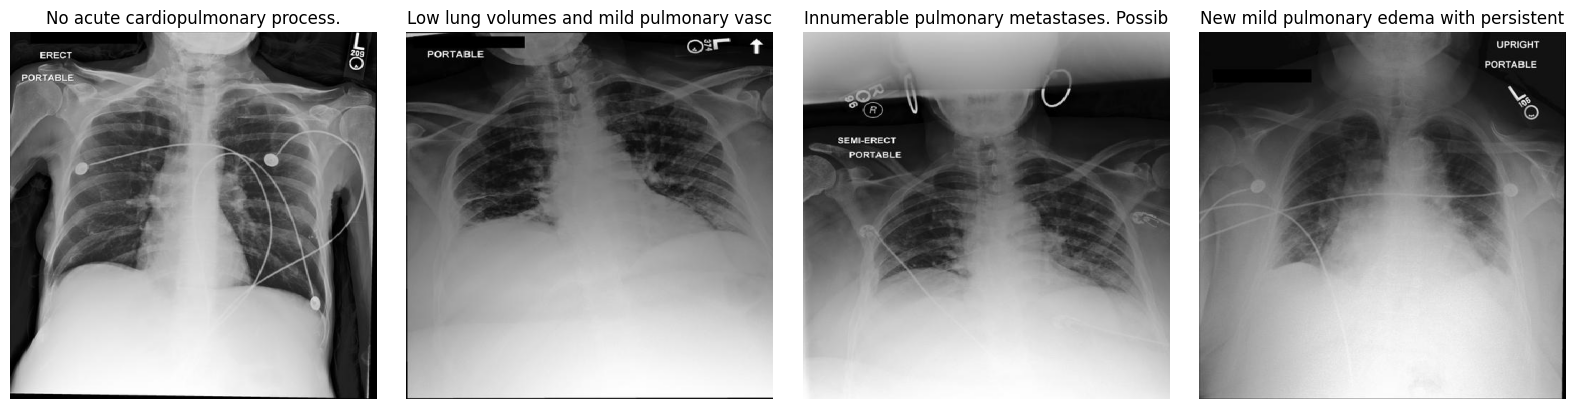

[0] No acute cardiopulmonary process.

[1] Low lung volumes and mild pulmonary vascular congestion is unchanged. New small right fissural pleural effusion. No new focal opacities to suggest pneumonia.

[2] Innumerable pulmonary metastases. Possible mild pulmonary vascular congestion. Low lung volumes.



In [12]:
# Visualize a few images with optional text snippet
n = min(4, len(train))
if n > 0:
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1: axes = [axes]
    for ax, ex in zip(axes, [train[i] for i in range(n)]):
        img = None
        if image_col:
            val = ex[image_col]
            if isinstance(val, Image.Image):
                img = val
            elif isinstance(val, (bytes, bytearray)):
                img = Image.open(io.BytesIO(val)).convert("L")
            elif isinstance(val, str) and os.path.exists(val):
                img = Image.open(val).convert("L")
        if img is not None:
            ax.imshow(img, cmap="gray")
            ax.set_title(str(ex.get(text_col, "")[:40]) if text_col else "")
            ax.axis("off")
        else:
            ax.text(0.5, 0.5, "No image", ha="center", va="center")
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# Show a couple of text snippets (if present)
if text_col:
    for i in range(min(3, len(train))):
        t = train[i].get(text_col, "")
        if isinstance(t, (list, tuple)):
            t = " ".join(map(str, t))
        print(f"[{i}] {t[:400]}\n")
else:
    print("No text-like column detected.")

## TASK 1

In [13]:
!pip -q install -U evaluate sacrebleu nltk rouge_score

In [14]:
!pip install -U "transformers>=4.41.0" timm accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 1.0.15
    Uninstalling timm-1.0.15:
      Successfully uninstalled timm-1.0.15


In [15]:
import os, math, itertools
import numpy as np
from tqdm import tqdm
from datasets import DatasetDict
from transformers import pipeline
import nltk
from transformers import pipeline, BlipProcessor, BlipForConditionalGeneration, AutoProcessor, LlavaForConditionalGeneration
import evaluate
from PIL import Image

2025-10-02 18:25:41.172029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759429541.196309     413 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759429541.203744     413 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
# -------------------
# Downloads needed for METEOR
# -------------------
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# -------------------
# Dataset selection
# -------------------
split_name = "test" if "test" in ds and len(ds["test"]) > 0 else "validation"
eval_ds = ds[split_name]
N_EVAL = min(200, len(eval_ds))  # adjust for speed
eval_ds = eval_ds.select(range(N_EVAL))

images = [x["image"] for x in eval_ds]
findings_refs = [x.get("findings", "") for x in eval_ds]
impression_refs = [x.get("impression", "") for x in eval_ds]

# -------------------
# Metrics
# -------------------
rouge = evaluate.load("rouge")
bleu  = evaluate.load("bleu")
meteor = evaluate.load("meteor")

def normalize(text: str) -> str:
    return " ".join((text or "").strip().split())

def compute_metrics(preds, refs):
    preds = [normalize(p) for p in preds]
    refs  = [normalize(r) for r in refs]
    r = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    b = bleu.compute(predictions=preds, references=[[r] for r in refs])
    m = meteor.compute(predictions=preds, references=refs)
    return {
        "rouge1": r["rouge1"],
        "rouge2": r["rouge2"],
        "rougeL": r["rougeL"],
        "bleu": b["bleu"],
        "meteor": m["meteor"],
    }

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
def batch_summarize(pipe, inputs, batch_size=8, **gen_kwargs):
    preds = []
    for i in range(0, len(inputs), batch_size):
        out = pipe(inputs[i:i+batch_size], **gen_kwargs)  # list[dict]{summary_text}
        preds.extend(normalize(x["summary_text"]) for x in out)
    return preds

def batch_textgen(pipe, prompts, batch_size=4, **gen_kwargs):
    preds = []
    for batch_start in range(0, len(prompts), batch_size):
        batch = prompts[batch_start : batch_start + batch_size]
        out = pipe(batch, **gen_kwargs)  # might be list of lists
        # flatten and extract text
        for gen_item, prompt in zip(out, batch):
            # gen_item can be a list of dicts or a string
            if isinstance(gen_item, list):
                # take first item if it's a list of dicts
                gen_item = gen_item[0] if gen_item else ""
            txt = gen_item if isinstance(gen_item, str) else gen_item.get("generated_text", "")
            # remove prompt if present
            txt = txt[len(prompt):] if txt.startswith(prompt) else txt
            preds.append(normalize(txt))
    return preds


def batch_img2text(pipe, imgs, batch_size=4, **gen_kwargs):
    preds = []
    for i in range(0, len(imgs), batch_size):
        out = pipe(imgs[i:i+batch_size], **gen_kwargs)
        # Handle both list[dict] and list[list[dict]] formats
        if isinstance(out[0], dict) and "generated_text" in out[0]:
            preds.extend(normalize(x["generated_text"]) for x in out)
        else:
            preds.extend(normalize(x[0]["generated_text"]) for x in out)
    return preds

In [19]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 12.4 MB/s eta 0:00:0000:010:01


In [20]:
# -------------------
# Models
# -------------------
DEVICE = 0  # GPU index on Kaggle

# Image -> Findings: BLIP (fallback baseline)
IMG2FIND_MODEL = "Salesforce/blip-image-captioning-large"
img2text = pipeline("image-to-text", model=IMG2FIND_MODEL, device=DEVICE)

# Findings -> Impression: medical summarizers
TXT_MODELS_SUMM = [
    "google/pegasus-pubmed",
    "GanjinZero/biobart-v2-large"
]

# Additional medical text LM for third baseline via prompting
TXT_MODEL_TEXTGEN = "microsoft/BioGPT-Large"
bio_lm = pipeline("text-generation", model=TXT_MODEL_TEXTGEN, device=DEVICE)

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


config.json:   0%|          | 0.00/658 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.29G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Device set to use cuda:0


In [21]:
# -------------------------
# Task A: Image -> Findings
# -------------------------
print("Running Task A: Image → Findings ...")
pred_findings_from_img = batch_img2text(img2text, images, batch_size=4, max_new_tokens=96)
metrics_img_to_find = compute_metrics(pred_findings_from_img, findings_refs)
print("[Image→Findings] BLIP:", metrics_img_to_find, "\n")

Running Task A: Image → Findings ...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[Image→Findings] BLIP: {'rouge1': 0.09279769376338151, 'rouge2': 0.006305556622108215, 'rougeL': 0.07699271939776872, 'bleu': 0.0, 'meteor': 0.030578926363578257} 



The low scores are not an error, they reflect the mismatch between BLIP training data (general images) and radiology images.

In [22]:
from transformers import logging
logging.set_verbosity_error()

# -----------------------------------
# Task B: Findings -> Impression
# -----------------------------------
print("Running Task B: Findings → Impression ...")
for m_id in TXT_MODELS_SUMM:
    summarizer = pipeline("summarization", model=m_id, device=DEVICE)
    preds = batch_summarize(summarizer, findings_refs, batch_size=8, max_new_tokens=128, truncation=True)
    metrics_find_to_impr = compute_metrics(preds, impression_refs)
    print(f"[Findings→Impression] {m_id}:", metrics_find_to_impr)

PROMPT_PREFIX = "Summarize the following chest X-ray findings into a concise clinical impression:\n\nFindings: "
PROMPT_SUFFIX = "\n\nImpression:"
prompts = [f"{PROMPT_PREFIX}{normalize(f)}{PROMPT_SUFFIX}" for f in findings_refs]
preds_biogpt = batch_textgen(bio_lm, prompts, batch_size=4, max_new_tokens=128, do_sample=False, num_beams=4)
metrics_biogpt = compute_metrics(preds_biogpt, impression_refs)
print(f"[Findings→Impression] {TXT_MODEL_TEXTGEN}:", metrics_biogpt, "\n")

Running Task B: Findings → Impression ...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

[Findings→Impression] google/pegasus-pubmed: {'rouge1': 0.07716080930290813, 'rouge2': 0.014292542971642081, 'rougeL': 0.06283665411650347, 'bleu': 0.007436804763271398, 'meteor': 0.11646282047698063}


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.77G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

[Findings→Impression] GanjinZero/biobart-v2-large: {'rouge1': 0.2688484143931308, 'rouge2': 0.1375635304826855, 'rougeL': 0.21987840217678295, 'bleu': 0.08431518454921456, 'meteor': 0.4024866094446105}
[Findings→Impression] microsoft/BioGPT-Large: {'rouge1': 0.09686831842451371, 'rouge2': 0.04244920555408656, 'rougeL': 0.08614048504675192, 'bleu': 0.021653652552323852, 'meteor': 0.16625729256820462} 



In [23]:
# --------------------------------------------------------
# Task C: Image + Findings -> Impression
# --------------------------------------------------------
print("Running Task C: Image+Findings → Impression ...")
concat_inputs = [
    f"Findings: {normalize(f)}\nImage summary: {normalize(c)}"
    for f, c in zip(findings_refs, pred_findings_from_img)
]
for m_id in TXT_MODELS_SUMM:
    summarizer_c = pipeline("summarization", model=m_id, device=DEVICE)
    preds_c = batch_summarize(summarizer_c, concat_inputs, batch_size=8, max_new_tokens=128, truncation=True)
    metrics_imgfind_to_impr = compute_metrics(preds_c, impression_refs)
    print(f"[Image+Findings→Impression] {m_id}:", metrics_imgfind_to_impr)

prompts_if = [
    "Given chest X-ray findings and an image-derived summary, write a concise clinical impression.\n\n"
    + ci + "\n\nImpression:" for ci in concat_inputs
]
preds_if_biogpt = batch_textgen(bio_lm, prompts_if, batch_size=4, max_new_tokens=128, do_sample=False, num_beams=4)
metrics_if_biogpt = compute_metrics(preds_if_biogpt, impression_refs)
print(f"[Image+Findings→Impression] {TXT_MODEL_TEXTGEN}:", metrics_if_biogpt)

Running Task C: Image+Findings → Impression ...
[Image+Findings→Impression] google/pegasus-pubmed: {'rouge1': 0.07327884840414885, 'rouge2': 0.009988930572467976, 'rougeL': 0.06068086099319582, 'bleu': 0.0047819051886051215, 'meteor': 0.10876062631115073}
[Image+Findings→Impression] GanjinZero/biobart-v2-large: {'rouge1': 0.22232564312748104, 'rouge2': 0.11175585564927859, 'rougeL': 0.17819458399704657, 'bleu': 0.06420298608092168, 'meteor': 0.3558153095500974}
[Image+Findings→Impression] microsoft/BioGPT-Large: {'rouge1': 0.11127991636762022, 'rouge2': 0.04796263116981096, 'rougeL': 0.09430544485619763, 'bleu': 0.023957428578344743, 'meteor': 0.1852648273125452}


Summary Table:

                        Task                        Model   ROUGE1   ROUGE2  \
0             Image→Findings                         BLIP  0.09296  0.00623   
1        Findings→Impression        google/pegasus-pubmed  0.07700  0.01400   
2        Findings→Impression  GanjinZero/biobart-v2-large  0.27000  0.13800   
3        Findings→Impression       microsoft/BioGPT-Large  0.09800  0.04300   
4  Image+Findings→Impression        google/pegasus-pubmed  0.07300  0.01000   
5  Image+Findings→Impression  GanjinZero/biobart-v2-large  0.22300  0.11200   
6  Image+Findings→Impression       microsoft/BioGPT-Large  0.11200  0.04800   

    ROUGEL   BLEU   METEOR  
0  0.07686  0.000  0.03057  
1  0.06200  0.007  0.11600  
2  0.22000  0.084  0.40200  
3  0.08600  0.022  0.16600  
4  0.06100  0.005  0.10900  
5  0.17800  0.064  0.35600  
6  0.09400  0.024  0.18500  


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


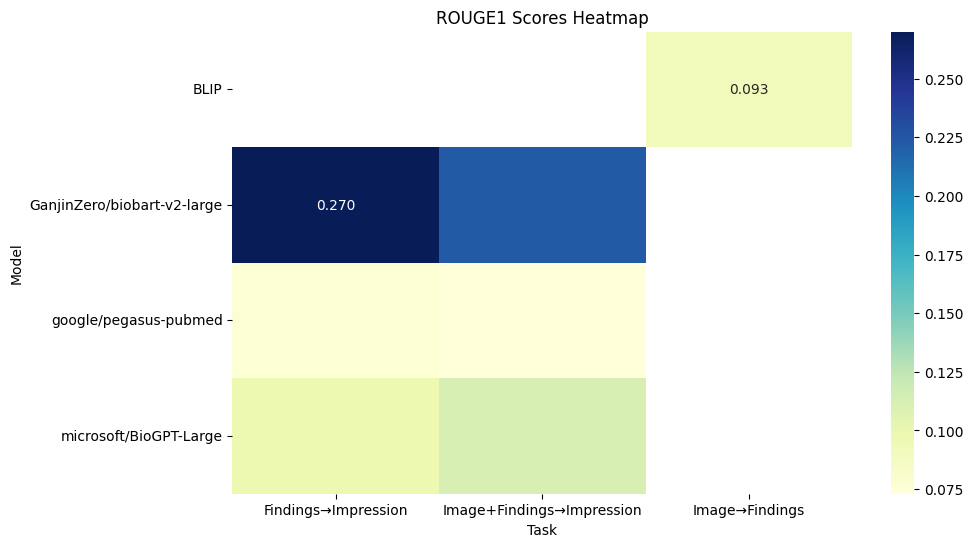

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Define results
# -----------------------------
results = {
    "Task": [],
    "Model": [],
    "ROUGE1": [],
    "ROUGE2": [],
    "ROUGEL": [],
    "BLEU": [],
    "METEOR": []
}

# Fill in your results
# Task A: Image -> Findings
results["Task"].append("Image→Findings")
results["Model"].append("BLIP")
results["ROUGE1"].append(0.09296)
results["ROUGE2"].append(0.00623)
results["ROUGEL"].append(0.07686)
results["BLEU"].append(0.0)
results["METEOR"].append(0.03057)

# Task B: Findings -> Impression
results["Task"].extend(["Findings→Impression"]*3)
results["Model"].extend([
    "google/pegasus-pubmed",
    "GanjinZero/biobart-v2-large",
    "microsoft/BioGPT-Large"
])
results["ROUGE1"].extend([0.077, 0.270, 0.098])
results["ROUGE2"].extend([0.014, 0.138, 0.043])
results["ROUGEL"].extend([0.062, 0.220, 0.086])
results["BLEU"].extend([0.007, 0.084, 0.022])
results["METEOR"].extend([0.116, 0.402, 0.166])

# Task C: Image+Findings -> Impression
results["Task"].extend(["Image+Findings→Impression"]*3)
results["Model"].extend([
    "google/pegasus-pubmed",
    "GanjinZero/biobart-v2-large",
    "microsoft/BioGPT-Large"
])
results["ROUGE1"].extend([0.073, 0.223, 0.112])
results["ROUGE2"].extend([0.010, 0.112, 0.048])
results["ROUGEL"].extend([0.061, 0.178, 0.094])
results["BLEU"].extend([0.005, 0.064, 0.024])
results["METEOR"].extend([0.109, 0.356, 0.185])

# -----------------------------
# Step 2: Convert to DataFrame
# -----------------------------
df = pd.DataFrame(results)
print("Summary Table:\n")
print(df)

# -----------------------------
# Step 3: Heatmap (ROUGE1, ROUGE2, ROUGEL)
# -----------------------------
# Pivot table for heatmap
pivot_df = df.pivot(index="Model", columns="Task", values="ROUGE1")

plt.figure(figsize=(10,6))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("ROUGE1 Scores Heatmap")
plt.show()
